# Přehled generovaných dat


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
import community

In [2]:
with open('data_generator/example_data.json') as f:
    data = eval(f.read())

## Přehled jednoho záznamu

In [3]:
type(data)

list

In [4]:
pprint(data[0])

{'coffee': 'coffee_21',
 'customer': 'customer_7',
 'rating': {'aroma': 41,
            'color': 37,
            'environment': 33,
            'service': 54,
            'smell': 28,
            'taste': 54}}


## Tvorba grafu

In [5]:
env_graph = nx.Graph()
taste_graph = nx.Graph()
graphs = [env_graph, taste_graph]
params = ['environment', 'taste']
customers = set()
coffees = set()
def checkNode(node, _set, _type, graphs):
    if not node in _set:
        _set.add(node)
        for G in graphs: G.add_node(node, type=_type)
    return node
def add_edges(customer, coffee, rating, graphs, params):
    for G, param in zip(graphs, params):
        G.add_edge(customer, coffee, weight=rating[param])
for rating in data:
    customer = checkNode(rating['customer'], customers, 0, graphs)
    coffee = checkNode(rating['coffee'], coffees, 1, graphs)
    add_edges(customer, coffee, rating['rating'], graphs, params)

In [6]:
print('pocet recenzi', len(env_graph.edges), len(taste_graph.edges))
print('pocet vrcholu', len(env_graph.nodes), len(taste_graph.nodes))
for t,T in enumerate(['uživatelů', 'kaváren']):
    print('z toho {}'.format(T), [len([n for n in G.nodes if G.nodes[n]['type'] == t]) for G in graphs])

pocet recenzi 750 750
pocet vrcholu 65 65
z toho uživatelů [15, 15]
z toho kaváren [50, 50]


## Uložení grafu

In [7]:
for G, param in zip(graphs, params):
    nx.write_gexf(G, 'graph_{}.gexf'.format(param))

## Vizualizace grafu
S detekcí komunit: https://github.com/taynaud/python-louvain.

In [8]:
def drawGraph(G):
    layout = nx.spring_layout(G)
    sizes = [45 if G.nodes[n]['type'] else 15 for n in G.nodes]
    partition = [community.best_partition(G)[n] for n in G.nodes]
    nx.draw(G, layout, node_size=sizes, node_color=partition)

### Graf hodnocení prostředí
Malé vrcholy jsou uživatelé, velké vrcholy jsou kavárny. Váha hrany představuje hodnocení prostředí kavárny uživatelem.  Barevně jsou rozlišeny skupiny vrcholů, které jsou mezi sebou vzájemně propojeny silněji, než s ostatními. Rozložení vrcholů v obrázku je dáno gravitačním modele: odpudivou silou jader vrcholů a přitažlivou silou hran. 

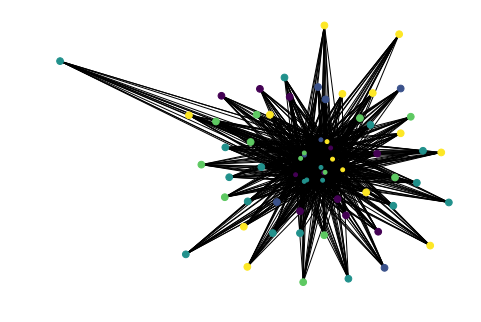

In [9]:
drawGraph(env_graph)

### Graf hodnocení chuti kávy
Váha hrany v grafu představuje hodnocení chuti kávy z kavárny (větší vrchol) uživatelem (menší vrchol).  Barevně jsou rozlišeny skupiny vrcholů, které jsou mezi sebou vzájemně propojeny silněji, než s ostatními. Rozložení vrcholů v obrázku je dáno gravitačním modele: odpudivou silou jader vrcholů a přitažlivou silou hran. 

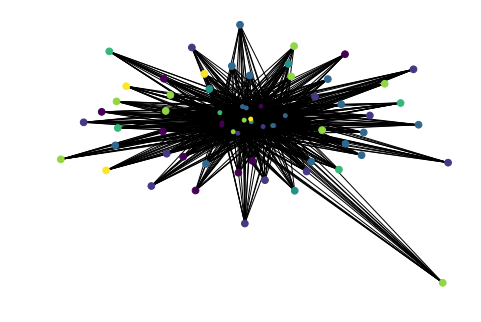

In [10]:
drawGraph(taste_graph)

## Matice sousednosti
Řádky a sloupce jsou zpermutovány (`sorted(G.nodes)`) tak, aby matice byla blokové. U bipartitního grafu můžou mít matice blokově nulovou diagonálu. 

In [11]:
def showAdjacency(G):
    adjacency = nx.adjacency_matrix(G, nodelist=sorted(G.nodes))
    plt.matshow(adjacency.todense())

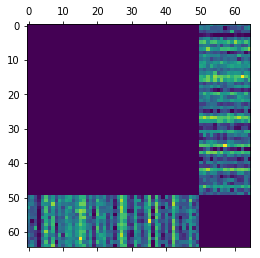

In [12]:
showAdjacency(env_graph)

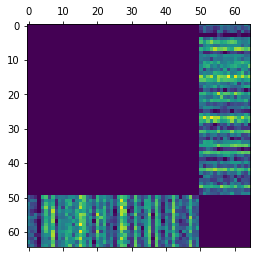

In [13]:
showAdjacency(taste_graph)

## Incidenční matice
U bipartitního grafu lze sestavit incidenční matici mezi vrcholy jednoho a druhého typu (tj. zákazníky a kavárny). 

In [14]:
def getIncidency(G):
    nodelist = sorted(G.nodes)
    adjacency = nx.adjacency_matrix(G, nodelist=nodelist).todense()
    types = [G.nodes[n]['type'] for n in nodelist]
    return adjacency[[n for n,t in enumerate(types) if t == 0]][:,[n for n,t in enumerate(types) if t == 1]]

In [15]:
def showIncidency(G, title=None):
    incidency = getIncidency(G)
    plt.matshow(incidency)
    plt.xlabel('kavárny')
    plt.ylabel('zákazníci')
    if title != None: plt.title(title)

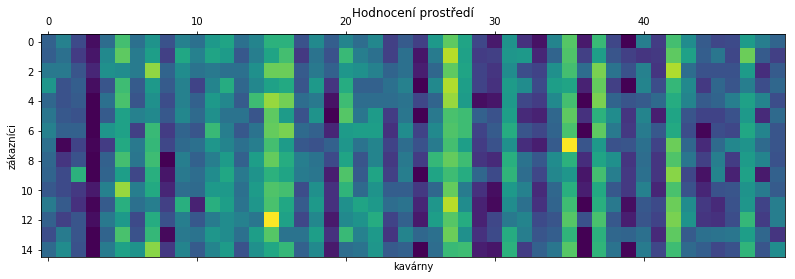

In [16]:
showIncidency(env_graph, 'Hodnocení prostředí')

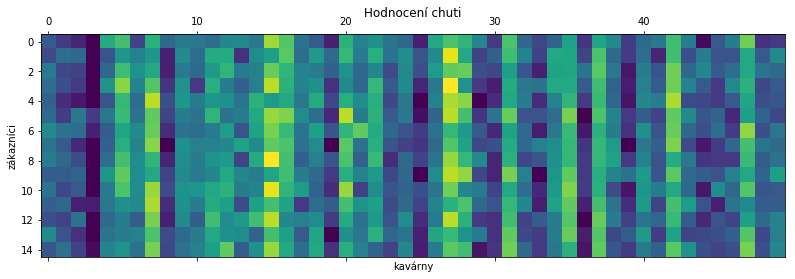

In [17]:
showIncidency(taste_graph, 'Hodnocení chuti')

## Biclustering
I. S. Dhillon, S. Mallela, D. S. Modha: Information-Theoretic Co-clustering

Biclustering umožňuje roztřídit kavárny a zákazníky do skupin a nalézt vazby mezi skupinami. 
De facto vyrobí pro každou skupinu typického zástupce a určí pro typickouu dvojici určí typickou/průměrnou recenzi. 
Tím lze předpovědět některé chybějící recenze od zákazníků. 

Biclustering pustíme na incidenční matici. Z výsledku klastrování lze sestavit aproximaci původní incidenční matice. V podstatě obsahuje i odhady chybějících recenzí. 

In [18]:
import sys
sys.path.append('c:\\Users\\Tomas\\Documents\\GIT\\14009soft\\TINcc')
import Itcc
import numpy as np

In [19]:
initRowClusters = [i % 10 for i,_ in enumerate(customers)]
initColumnClusters = [i % 10 for i,_ in enumerate(coffees)]
incidencyMatrix = getIncidency(taste_graph)
model = Itcc.ItccModel(incidencyMatrix/np.sum(incidencyMatrix), initRowClusters, initColumnClusters)
itcc = Itcc.Itcc()
itcc.updateClusterMatrices(model)
itcc.updatePs(model)

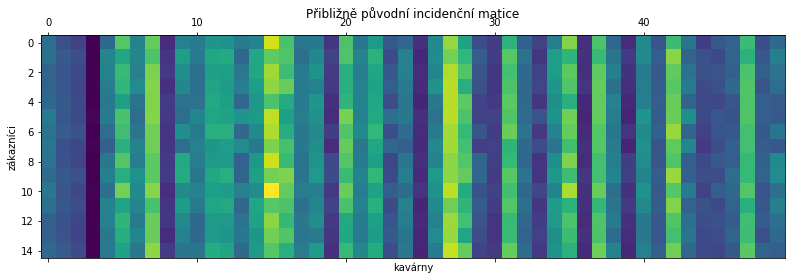

In [20]:
plt.matshow(model.Q);
plt.xlabel('kavárny');
plt.ylabel('zákazníci');
plt.title('Přibližně původní incidenční matice');

In [21]:
itcc.Iteration(model)
itcc.Evaluation(model)

4884.421663685411

In [22]:
itcc.Iteration(model)
itcc.Evaluation(model)

4884.370122023218

In [23]:
itcc.Iteration(model)
itcc.Evaluation(model)

4884.370122023218

In [24]:
itcc.Iteration(model)
itcc.Evaluation(model)

4884.370122023218

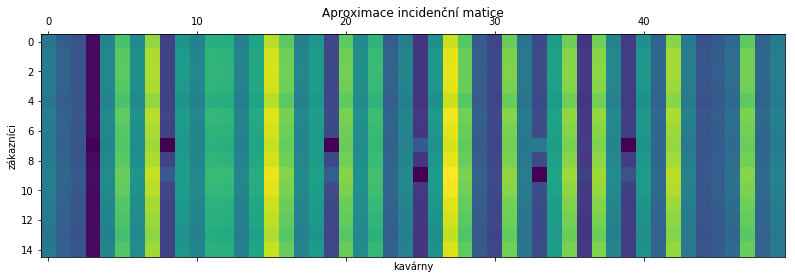

In [25]:
plt.matshow(model.Q);
plt.xlabel('kavárny');
plt.ylabel('zákazníci');
plt.title('Aproximace incidenční matice');

## Typická hodnocení
Výsledkem klastrování jsou skupiny zákazníků reprezentované typickým zákazníkem, skupiny kaváren zastoupené typickou kavárnou a typickým hodnocením typické kavárny typickým zákazníkem. 

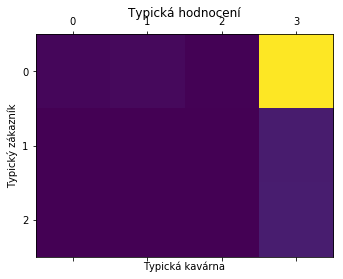

In [26]:
plt.matshow(model.PXhatYhat);
plt.title('Typická hodnocení');
plt.xlabel('Typická kavárna');
plt.ylabel('Typický zákazník');

In [27]:
print('Počty zákazníků ve skupinách') 
print('\tSkupina\tPočet')
for n,v in enumerate(model.CX @ np.ones((model.CX.shape[1],1))): print('\t{}\t{}'.format(n,v))

Počty zákazníků ve skupinách
	Skupina	Počet
	0	[13.]
	1	[1.]
	2	[1.]


In [28]:
print('Počty kaváren ve skupinách') 
print('\tSkupina\tPočet')
for n,v in enumerate(model.CY @ np.ones((model.CY.shape[1],1))): print('\t{}\t{}'.format(n,v))

Počty kaváren ve skupinách
	Skupina	Počet
	0	[2.]
	1	[4.]
	2	[1.]
	3	[43.]


## Závěr
Algoritmus našel 3 třídy uživatelů a 4 skupiny kaváren. Většina zákazníků a kaváren jsou v jedné skupině a mají pozitivní typickou recenzi. 

Biklastrovací metoda vyžaduje zadat maximální počty klastrů a počáteční rozdělení. Podle toho se odvíjí výsledek. Metodu jsem spustil v úplně základním stavu. 